# lab 7

# Supermodeling

## What is supermodeling

## Used Data Assimilation method

## Submodels

## Lorenz again

![Lorenz equations](images/lorenz.png)

source: https://en.wikipedia.org/wiki/Lorenz_system

### Utilities

In [3]:
from operator import itemgetter
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D
import time
from math import ceil
from data_assimilation import assimilateLorenz
%matplotlib inline

In [32]:
def timeit(method):
    def timed(*args, **kw):
        ts = time.time()
        result = method(*args, **kw)
        te = time.time()
        if 'log_time' in kw:
            name = kw.get('log_name', method.__name__.upper())
            kw['log_time'][name] = int((te - ts) * 1000)
        else:
            print('%r  %2.2f ms' % \
                  (method.__name__, (te - ts) * 1000))
        return result
    return timed


def plot_models(models, timelines=None, figsize=(8,8)):
    fig = plt.figure(figsize=figsize)
    ax = fig.gca(projection="3d")
    for piece in models:
            ax.plot(piece[:, 0].flatten(), piece[:, 1].flatten(), piece[:, 2].flatten(), lw=0.5)
    plt.draw()
    plt.show()
    
    if timelines:
        plot_models_coords_in_time(models, timelines)
    
def plot_model(model, timeline=None, figsize=(5,5)):
    plot_models([model], figsize=figsize)
    if timeline is not None:
        plot_model_coords_in_time(model, timeline)

    
def calc_mean_lorenz(lorenz_models):
    return np.array([np.mean(lorenz_models[:,i,:], axis=0) for i in range(lorenz_models.shape[1])])


def calc_weighted_average_lorenz(lorenz_models, weights):
    return np.array([np.average(lorenz_models[:,i,:], axis=0, weights=weights) for i in range(lorenz_models.shape[1])])

def lorenz_step(coords, parameters, dt=0.01):
    rho, sigma, beta = parameters
    x, y, z = coords
    return coords + (np.array([sigma * (y - x), x * (rho - z) - y, x * y - beta * z]) * dt)

def generate_lorenz(x=1, y=1, z=1, sigma=10.0, rho=28.0, beta=8.0/3.0, start_time=0.0, number_of_samples=4000, dt=0.01, plot=False):
    size = number_of_samples
    
    if start_time:
        size += ceil(start_time/dt)

    coords = np.empty([size,3])

    coords[0] = [x,y,z]
    parameters = [rho, sigma, beta]
    for i in range(size - 1):
        coords[i+1] = lorenz_step(coords[i],parameters, dt=dt)
    coords= coords[-number_of_samples:]
    if plot:
        plot_model(coords)
    return coords, np.arange(start_time, start_time + number_of_samples * dt, dt)

def plot_models_coords_in_time(models, timelines):
    f, (px, py, pz) = plt.subplots(3, 1, sharex=True, figsize=(15,8))

    px.set_ylabel("X component")
    py.set_ylabel("Y component")
    pz.set_ylabel("Z component")
    
    for ix, (model, timeline) in enumerate(zip(models, timelines)):
        px.plot(timeline, model[:,0], lw=0.5)
        py.plot(timeline, model[:,1], lw=0.5)
        pz.plot(timeline, model[:,2], lw=0.5, label=str(ix+1))

    pz.set_xlabel("Time index (x 100)")
    
    f.legend(title="Models in order")
    

def plot_model_coords_in_time(model, timeline):
    plot_models_coords_in_time([model], [timeline])
    
def lorenz_research(
    start_time = 4.5,
    number_of_samples = 200,
    steps_4dvar = 20,
    small_plot = True,
    full_plot = True,
    initial_params = None
):
    l63_gt, l63_timeline_gt = generate_lorenz(
        start_time=start_time, 
        number_of_samples=number_of_samples
    )
    
    
    initial = dict(
        x=l63_gt[0][0], 
        y=l63_gt[0][1],
        z=l63_gt[0][2],
        sigma = 10.0,
        rho = 20.,
        beta = 5.
    )
    
    if initial_params is not None:
        initial.update(initial_params)
    
    error_vector = [0.1, 0.1, 0.1, 100, 100, 100]
    
    coords_and_params = assimilateLorenz(
        initial, 
        l63_gt,
        lorenz_step, 
        maximum_number_of_steps=steps_4dvar,
        verbose=True, 
        error_vector=error_vector
    )
    l63_4dv, l63_4dv_timeline = generate_lorenz(
        x=l63_gt[0][0], 
        y=l63_gt[0][1],
        z=l63_gt[0][2],
        sigma=coords_and_params['sigma'],
        rho=coords_and_params['rho'],
        beta=coords_and_params['beta'],
        number_of_samples=number_of_samples
    )
    
    print(l63_gt, l63_timeline_gt)
    
    if small_plot:
        plot_models(
            [l63_gt, l63_4dv],
            [l63_timeline_gt, l63_timeline_gt]
        )
    
    
    full_lorenz, fl_timeline = generate_lorenz()
    full_predicted, full_pred_timeline = generate_lorenz(sigma=coords_and_params['sigma'],rho=coords_and_params['rho'],beta=coords_and_params['beta'])
        
    if full_plot:
        plot_models([full_lorenz, full_predicted], [fl_timeline, full_pred_timeline])
        
    return {
        'partial': {
            'gt': [l63_gt, l63_timeline_gt],
            'pred': [l63_4dv, l63_4dv_timeline],
        },
        'full': {
            'gt': [full_lorenz, fl_timeline],
            'pred': [full_predicted, full_pred_timeline],
        }
    }

def set_submodel_consts(
    number_of_samples = 200,
    steps_4dvar = 20
):    
    def create_submodel(sigma, rho, beta, start_time = 4.5):
            
        return lorenz_research(    
            start_time = start_time,
            number_of_samples = number_of_samples,
            steps_4dvar = steps_4dvar,
            small_plot = True,
            full_plot = False,
            initial_params = dict(sigma=sigma,rho=rho,beta=beta)
        )

    return create_submodel

### Sandbox

In [ ]:
# generate and plot lorenz attractor
lorenz_attr, lorenz_timeline = generate_lorenz()
plot_model(lorenz_attr, lorenz_timeline)

In [ ]:
model_coords = [np.array([1,1,1])]
model_coords.append([np.array(model_coords[-1]) + np.array(np.array(lorenz_step(model_coords[-1], [18.0, 7.0, 3.7])) * dt)])

In [ ]:
model_1_params = dict(
    x = 1,
    y = 1,
    z = 1,
    sigma = 13.25,
    rho = 19.0,
    beta = 3.5
)

model_2_params = dict(
    x = 1,
    y = 1,
    z = 1,
    sigma = 7.0,
    rho = 18.0,
    beta = 3.7
)


model_3_params = dict(
    x = 1,
    y = 1,
    z = 1,
    sigma = 6.5,
    rho = 38.0,
    beta = 1.7
)

models_start = 15
number_of_samples = 200

m1, t1 = generate_lorenz(start_time=models_start, number_of_samples=number_of_samples,**model_1_params)
m2, t2 = generate_lorenz(start_time=models_start, number_of_samples=number_of_samples, **model_2_params)
m3, t3 = generate_lorenz(start_time=models_start, number_of_samples=number_of_samples, **model_3_params)

In [ ]:
plot_models([m1,m2,m3])
plot_models_coords_in_time([m1,m2,m3], [t1,t2,t3])

In [ ]:
mean_model = calc_mean_lorenz(np.array([m1, m2, m3]))
plot_model(mean_model)

In [ ]:
weighted_avg_model = calc_weighted_average_lorenz(
    np.array([m1, m2, m3]),
    [0.1,0.1,0.8]
)

plot_model(weighted_avg_model)
plot_model_coords_in_time(weighted_avg_model, t1)

In [ ]:
weighted_avg_model = calc_weighted_average_lorenz(
    np.array([m1, m2, m3]),
    [1,1,3]
)

plot_models([lorenz_attr,weighted_avg_model])

In [ ]:
lorenz, lorenz_timeline = generate_lorenz()
plot_model(lorenz)
plot_model_coords_in_time(lorenz, lorenz_timeline)

## Task 1. Choose a fragment of lorenz 63 attractor

In the first task you have to sample a chosen part of Lorenz attractor. \
Remember that the attractor uses time so in other word `models_start` variable \
is a time from which we start sampling with `dt = 0.01` so plots are smoother.

In [7]:
# TODO: find fancy, not too long trajectory of L63
model_start = ???
number_of_samples = ???

SyntaxError: invalid syntax (<ipython-input-7-a1509c388cd4>, line 2)

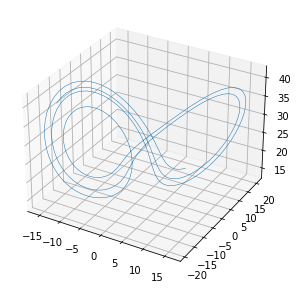

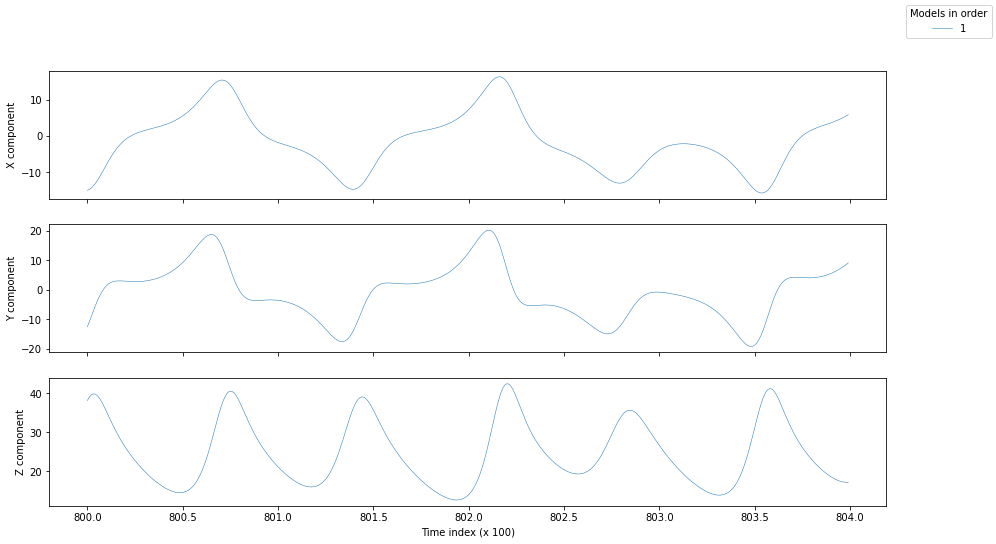

In [6]:
l63, l63_timeline = generate_lorenz(
    start_time=model_start, 
    number_of_samples=number_of_samples
)
plot_model(l63)
plot_model_coords_in_time(l63, l63_timeline)

## Task 2 - have fun with 4dvar

So you know how to sample L63 trajectory. \
Now you will use 4dvar to predict lorenz64 parameters.
Find out how many samples are needed so we can say that the prediction is ok. \
`number_of_samples` should be less than `200`, otherwise the prediction would have taken too much time.
Try few options each one in new cell so you can compare your results. \
TIP: play on full range i.e. [5, 200] and put `;` on the end of the method.

In [31]:
lorenz_research(
    number_of_samples=???
);

SyntaxError: invalid syntax (<ipython-input-31-d64dc7cfc6d1>, line 1)

## Task 3 - play with iterations

4dvar assimilation does iterations and during each one it gets closer \
to the solution. Play with them.


In [ ]:
lorenz_research(
    number_of_samples=???,
    steps_4dvar=???
);

## Task 4 - create submodels

Now we will use the idea that some pretrained models can be connected to create new, \
better one. In this task you have to create 3 submodels with chosen by you \
init values. We hope you have some intuition after previous tasks so you can \
chose them wisely.

In [33]:
submodel_creator = set_submodel_consts(
    number_of_samples = ???,
    steps_4dvar = ???
)

  Intermediate CurrentState at the current iteration: [10.14216278  8.53511209 30.91601828 20.         10.          5.        ]
  Intermediate CurrentState at the current iteration: [10.10685604  9.29708713 31.28505945 20.19708623  9.99599448  4.50695127]
  Intermediate CurrentState at the current iteration: [ 9.90898345 10.18623325 31.4927129  20.57397396  9.99783864  3.82501083]
  Intermediate CurrentState at the current iteration: [ 9.85644121 10.15445171 31.38713233 20.71358623  9.99827545  3.66439948]
  Intermediate CurrentState at the current iteration: [10.00636367  9.49141873 30.45845451 22.4043084   9.99247788  1.86285075]
  Intermediate CurrentState at the current iteration: [ 9.8957296   9.53809167 29.74152454 23.41362271  9.99038173  1.94389965]
  Intermediate CurrentState at the current iteration: [ 9.95808003  9.51178804 30.14556726 22.84479993  9.99156306  1.89822264]
  Intermediate CurrentState at the current iteration: [ 9.93920302  9.50471155 30.28953136 22.80507378  

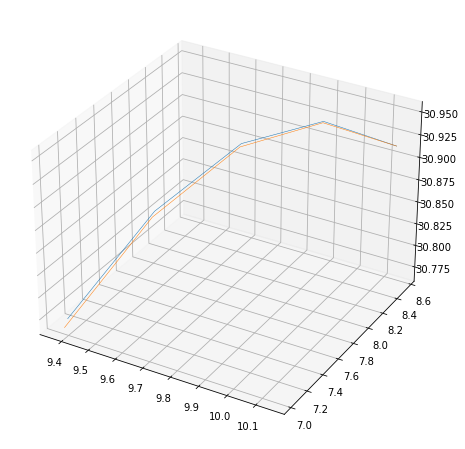

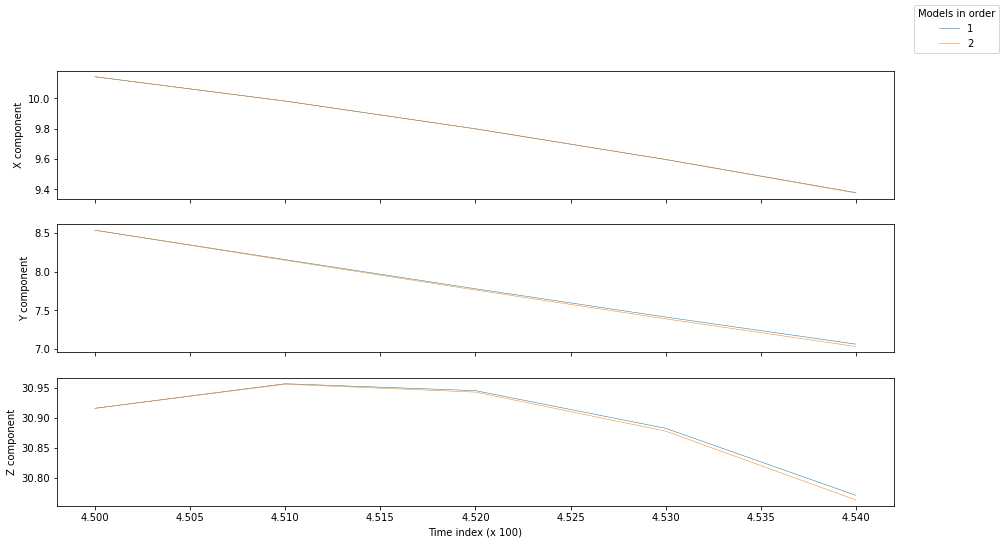

In [34]:
sm1 = submodel_creator(
    sigma=???,
    rho=???,
    beta=???,
    start_time=???
)

In [ ]:
sm2 = submodel_creator(
    sigma=???,
    rho=???,
    beta=???,
    start_time=???
)

In [ ]:
sm3 = submodel_creator(
    sigma=???,
    rho=???,
    beta=???,
    start_time=???
)

In [ ]:
plot_models([
    sm1['full']['pred'][0],
    sm2['full']['pred'][0],
    sm3['full']['pred'][0],
],
[
    sm1['full']['pred'][1],
    sm2['full']['pred'][1],
    sm3['full']['pred'][1],
]
)

In [ ]:
mean_submodel = calc_mean_lorenz(np.array([
    sm1['full']['pred'][0],
    sm2['full']['pred'][0],
    sm3['full']['pred'][0],
]))

plot_models([sm1['full']['gt'][0], mean_submodel], [sm1['full']['gt'][1], sm1['full']['gt'][1]])

## Task 5 - mean average from submodels

Some times one of your model can be better than others so its importance \
might be higher than others. Try to find best weights for weight average of your submodels.

In [ ]:
weights = [?,?,?]

mean_submodel = calc_weighted_average_lorenz(np.array([
        sm1['full']['pred'][0],
        sm2['full']['pred'][0],
        sm3['full']['pred'][0],
    ]),
    weights
)

plot_models([sm1['full']['gt'][0], mean_submodel], [sm1['full']['gt'][1], sm1['full']['gt'][1]])